# OLX Store Sales Forecasting 

[Muhammad Abuzar](https://www.github.com/abuzariii)

We have the historical sales data for 45 OLX stores located in different regions. Each store contains a number of departments, and we are tasked with predicting the department-wide sales for each store.

### The Dataset Structure

We have mainly four relevant csv files:  
    \- **stores.csv**: This file contains anonymized information about the 45 stores, indicating the type and size of store.  
    \- **train.csv**: This is the historical training data, which covers to 2010-02-05 to 2012-11-01.  
    \- **test.csv**: This file is identical to train.csv, except we have withheld the weekly sales. We must predict the sales for each triplet of store, department, and date in this file.  
    \- **features.csv**: This file contains additional data related to the store, department, and regional activity for the given dates.

The **train.csv** has the following fields:  
    
- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales - sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week


The **features.csv** has the fields:  
    
- Store - the store number
- Date - the week
- Temperature - average temperature in the region
- Fuel_Price - cost of fuel in the region
- MarkDown1 to MarkDown5 - anonymized data related to promotional markdowns that OLX is running. MarkDown data is only available after Nov 2018, and is not available for all stores all the time. Any missing value is marked with an NA.
- CPI - the consumer price index
- Unemployment - the unemployment rate
- IsHoliday - whether the week is a special holiday week


### Importing the libraries

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime

from scipy.stats import probplot
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing, Holt

from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.stattools import adfuller

sns.set_style('darkgrid')

from warnings import filterwarnings
filterwarnings('ignore')

### Loading the Data

In [2]:
train = pd.read_csv('data/train.csv')
stores = pd.read_csv('data/stores.csv')
features = pd.read_csv('data/features.csv')

In [3]:
train.head()

Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

In [4]:
stores.head()

Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

In [5]:
features.head()

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False

## Data Preprocessing

### Checking for Null Values

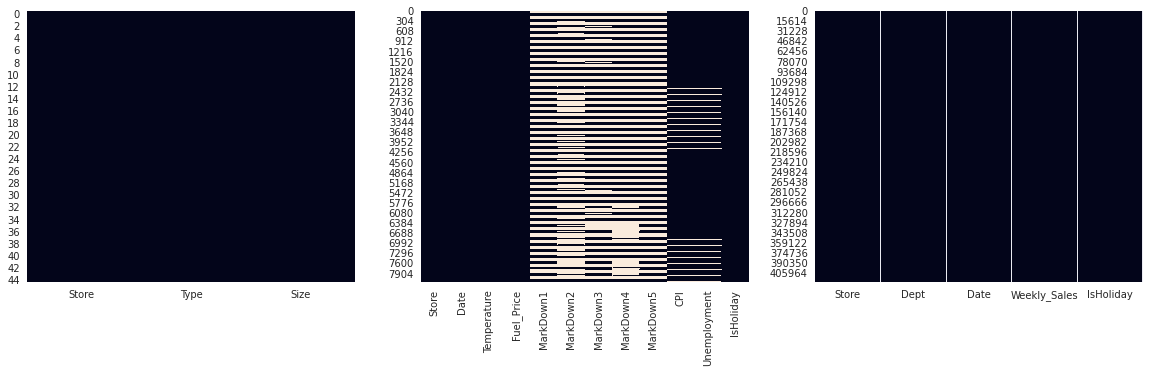

In [6]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.heatmap(stores.isna(), cbar = False)
plt.subplot(1,3,2)
sns.heatmap(features.isna(), cbar = False)
plt.subplot(1,3,3)
sns.heatmap(train.isna(), cbar = False)
plt.show()

We can observe that there are null values in the **features** dataset in 7 of the columns.  

- *MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5, CPI and Unemployment*

We can count the instances of null values in each of the columns.

In [7]:
features.isna().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

### Combining Datasets

We can *inner join* the **train** and **features** datasets based on *\[Store, Date]* key.

In [8]:
temp = pd.merge(left = train, right = features ,on = ['Store', 'Date'], how = 'inner')
temp.head()

Store  Dept        Date  Weekly_Sales  IsHoliday_x  Temperature  \
0      1     1  2010-02-05      24924.50        False        42.31   
1      1     2  2010-02-05      50605.27        False        42.31   
2      1     3  2010-02-05      13740.12        False        42.31   
3      1     4  2010-02-05      39954.04        False        42.31   
4      1     5  2010-02-05      32229.38        False        42.31   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        NaN        NaN        NaN        NaN        NaN   
1       2.572        NaN        NaN        NaN        NaN        NaN   
2       2.572        NaN        NaN        NaN        NaN        NaN   
3       2.572        NaN        NaN        NaN        NaN        NaN   
4       2.572        NaN        NaN        NaN        NaN        NaN   

          CPI  Unemployment  IsHoliday_y  
0  211.096358         8.106        False  
1  211.096358         8.106        False  
2  211.096358         8.106        False  
3  211.096358         8.106        False  
4  211.096358         8.106        False

Now we will again *inner join* this with stores.

In [9]:
data = temp.merge(stores, on = ['Store'], how = 'inner')
data.head()

Store  Dept        Date  Weekly_Sales  IsHoliday_x  Temperature  \
0      1     1  2010-02-05      24924.50        False        42.31   
1      1     2  2010-02-05      50605.27        False        42.31   
2      1     3  2010-02-05      13740.12        False        42.31   
3      1     4  2010-02-05      39954.04        False        42.31   
4      1     5  2010-02-05      32229.38        False        42.31   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        NaN        NaN        NaN        NaN        NaN   
1       2.572        NaN        NaN        NaN        NaN        NaN   
2       2.572        NaN        NaN        NaN        NaN        NaN   
3       2.572        NaN        NaN        NaN        NaN        NaN   
4       2.572        NaN        NaN        NaN        NaN        NaN   

          CPI  Unemployment  IsHoliday_y Type    Size  
0  211.096358         8.106        False    A  151315  
1  211.096358         8.106        False    A  151315  
2  211.096358         8.106        False    A  151315  
3  211.096358         8.106        False    A  151315  
4  211.096358         8.106        False    A  151315

In [10]:
data.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size'],
      dtype='object')

Here now we have our entire combined data.

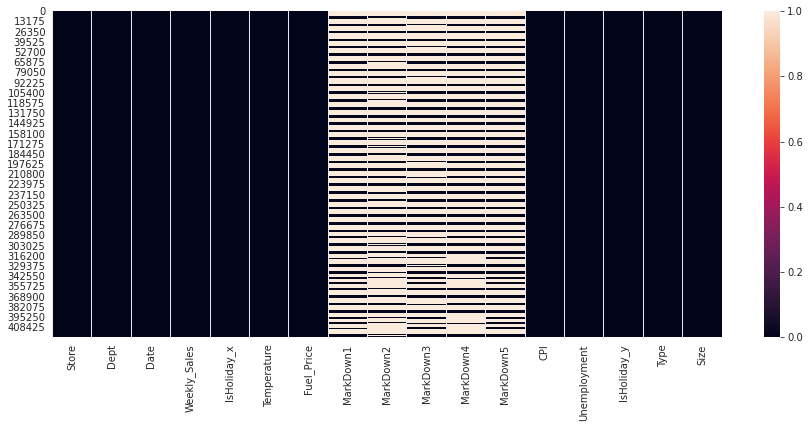

In [11]:
plt.figure(figsize=(15,6))
sns.heatmap(data.isna());

Now we will remove duplicate ***is_holiday*** column and renaming it.

In [12]:
data.drop('IsHoliday_y', axis = 1, inplace  = True)
data = data.rename(columns = {'IsHoliday_x' : 'IsHoliday'})

In [13]:
data.head()

Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1  2010-02-05      24924.50      False        42.31       2.572   
1      1     2  2010-02-05      50605.27      False        42.31       2.572   
2      1     3  2010-02-05      13740.12      False        42.31       2.572   
3      1     4  2010-02-05      39954.04      False        42.31       2.572   
4      1     5  2010-02-05      32229.38      False        42.31       2.572   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.096358   
2        NaN        NaN        NaN        NaN        NaN  211.096358   
3        NaN        NaN        NaN        NaN        NaN  211.096358   
4        NaN        NaN        NaN        NaN        NaN  211.096358   

   Unemployment Type    Size  
0         8.106    A  151315  
1         8.106    A  151315  
2         8.106    A  151315  
3         8.106    A  151315  
4         8.106    A  151315

The data source mentioned the **Special Holidays** which are encorporated in ***IsHoliday*** column but not separately.  
So we will just add theses as separate columns for analysis.

In [14]:
data['Super_Bowl'] = np.where((data['Date'] == datetime(2010,2,10)) | (data['Date'] == datetime(2011,2,11)) | 
                               (data['Date'] == datetime(2012,2,10)) | (data['Date'] == datetime(2013,2,8)), 1, 0)
data['Labor_day'] = np.where((data['Date'] == datetime(2010,9,10)) | (data['Date'] == datetime(2011,9,9)) | 
                              (data['Date'] == datetime(2012,9,7)) | (data['Date'] == datetime(2013,9,6)), 1, 0)
data['Thanksgiving'] = np.where((data['Date']==datetime(2010, 11, 26)) | (data['Date']==datetime(2011, 11, 25)) | 
                                 (data['Date']==datetime(2012, 11, 23)) | (data['Date']==datetime(2013, 11, 29)),1,0)
data['Christmas'] = np.where((data['Date']==datetime(2010, 12, 31)) | (data['Date']==datetime(2011, 12, 30)) | 
                              (data['Date']==datetime(2012, 12, 28)) | (data['Date']==datetime(2013, 12, 27)),1,0)

Now we can check our new data for the missing values.

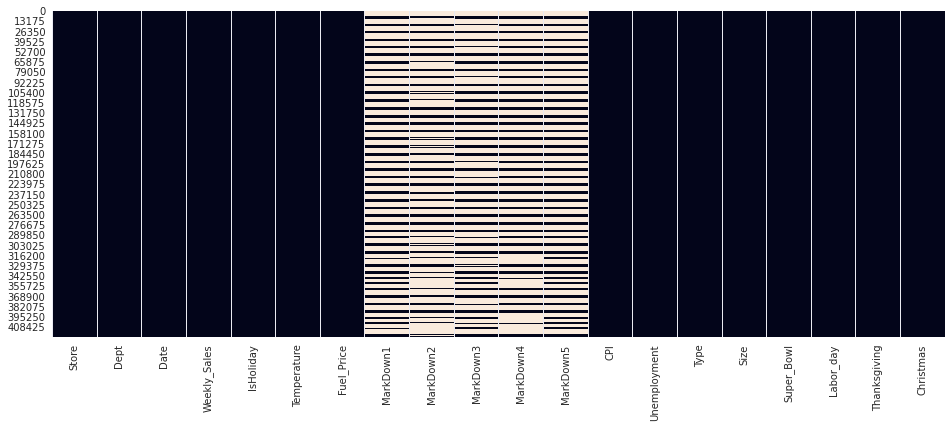

In [15]:
plt.figure(figsize=(16,6))
sns.heatmap(data.isna(), cbar = False)
plt.show()

So after combining data corresponding to the **train** dataset we can see we are only left with the missing values in *Markdown\** columns.

We can replace these with 0 to represent absent markdowns

In [16]:
data = data.fillna(0)
data.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Super_Bowl      0
Labor_day       0
Thanksgiving    0
Christmas       0
dtype: int64

In [17]:
data.describe()

Store           Dept   Weekly_Sales    Temperature  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean       22.200546      44.260317   15981.258123      60.090059   
std        12.785297      30.492054   22711.183519      18.447931   
min         1.000000       1.000000   -4988.940000      -2.060000   
25%        11.000000      18.000000    2079.650000      46.680000   
50%        22.000000      37.000000    7612.030000      62.090000   
75%        33.000000      74.000000   20205.852500      74.280000   
max        45.000000      99.000000  693099.360000     100.140000   

          Fuel_Price      MarkDown1      MarkDown2      MarkDown3  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean        3.361027    2590.074819     879.974298     468.087665   
std         0.458515    6052.385934    5084.538801    5528.873453   
min         2.472000       0.000000    -265.760000     -29.100000   
25%         2.933000       0.000000       0.000000       0.000000   
50%         3.452000       0.000000       0.000000       0.000000   
75%         3.738000    2809.050000       2.200000       4.540000   
max         4.468000   88646.760000  104519.540000  141630.610000   

           MarkDown4      MarkDown5            CPI   Unemployment  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean     1083.132268    1662.772385     171.201947       7.960289   
std      3894.529945    4207.629321      39.159276       1.863296   
min         0.000000       0.000000     126.064000       3.879000   
25%         0.000000       0.000000     132.022667       6.891000   
50%         0.000000       0.000000     182.318780       7.866000   
75%       425.290000    2168.040000     212.416993       8.572000   
max     67474.850000  108519.280000     227.232807      14.313000   

                Size  Super_Bowl  Labor_day  Thanksgiving  Christmas  
count  421570.000000    421570.0   421570.0      421570.0   421570.0  
mean   136727.915739         0.0        0.0           0.0        0.0  
std     60980.583328         0.0        0.0           0.0        0.0  
min     34875.000000         0.0        0.0           0.0        0.0  
25%     93638.000000         0.0        0.0           0.0        0.0  
50%    140167.000000         0.0        0.0           0.0        0.0  
75%    202505.000000         0.0        0.0           0.0        0.0  
max    219622.000000         0.0        0.0           0.0        0.0

In [18]:
data[data['Weekly_Sales'] < 0]

Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  \
188         1    47  2010-02-19       -863.00      False        39.93   
406         1    47  2010-03-12       -698.00      False        57.79   
2549        1    47  2010-10-08        -58.00      False        63.93   
3632        1    54  2011-01-21        -50.00      False        44.04   
4419        1    47  2011-04-08       -298.00      False        67.84   
...       ...   ...         ...           ...        ...          ...   
419999     45    49  2012-05-18         -3.97      False        66.30   
420066     45    49  2012-05-25         -4.97      False        67.21   
420403     45    49  2012-06-29        -34.00      False        75.22   
420736     45    49  2012-08-03         -1.91      False        76.58   
421142     45    49  2012-09-14         -6.83      False        67.87   

        Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
188          2.514       0.00       0.00       0.00       0.00       0.00   
406          2.667       0.00       0.00       0.00       0.00       0.00   
2549         2.633       0.00       0.00       0.00       0.00       0.00   
3632         3.016       0.00       0.00       0.00       0.00       0.00   
4419         3.622       0.00       0.00       0.00       0.00       0.00   
...            ...        ...        ...        ...        ...        ...   
419999       3.848    6813.74       0.00      13.86     936.49    2941.55   
420066       3.798    5370.39       0.00     361.22    1287.62    2461.81   
420403       3.506    3291.36     425.60       0.00     314.88    2255.34   
420736       3.654   24853.05      39.56      17.96   11142.69    2768.32   
421142       3.948   11407.95       0.00       4.30    3421.72    5268.92   

               CPI  Unemployment Type    Size  Super_Bowl  Labor_day  \
188     211.289143         8.106    A  151315           0          0   
406     211.380643         8.106    A  151315           0          0   
2549    211.746754         7.838    A  151315           0          0   
3632    211.827234         7.742    A  151315           0          0   
4419    215.074394         7.682    A  151315           0          0   
...            ...           ...  ...     ...         ...        ...   
419999  190.996448         8.567    B  118221           0          0   
420066  191.002810         8.567    B  118221           0          0   
420403  191.099246         8.567    B  118221           0          0   
420736  191.164090         8.684    B  118221           0          0   
421142  191.699850         8.684    B  118221           0          0   

        Thanksgiving  Christmas  
188                0          0  
406                0          0  
2549               0          0  
3632               0          0  
4419               0          0  
...              ...        ...  
419999             0          0  
420066             0          0  
420403             0          0  
420736             0          0  
421142             0          0  

[1285 rows x 20 columns]

In [19]:
print("Number of observations with negative sales is ", len(data[data['Weekly_Sales'] < 0]))

Number of observations with negative sales is  1285


We will remove these observations

In [20]:
data = data[data['Weekly_Sales'] >= 0]

In [21]:
print('Final Shape of the Data : ',data.shape)

Final Shape of the Data :  (420285, 20)


___

We will first need to parse the dates correctly

In [23]:
data['Date'] = pd.to_datetime(data['Date'])

data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.week
data['Day'] = data['Date'].dt.day

## Time Series Modeling

#### Resampling

We have resampled the data monthly, weekly and quarterly.  

In [24]:
df_weekly = data.copy().set_index('Date')['Weekly_Sales']
df_weekly = df_weekly.resample('W').mean()

In [25]:
df_monthly = data.copy().set_index('Date')['Weekly_Sales']
df_monthly = df_monthly.resample('MS').mean()

In [26]:
df_quarterly = data.copy().set_index('Date')['Weekly_Sales']
df_quarterly = df_quarterly.resample('Q').mean()

We'll hold some points for the testing part

In [27]:
train_data_m = df_monthly[:int(0.7*(len(df_monthly)))]
test_data_m = df_monthly[int(0.7*(len(df_monthly))):]

In [28]:
train_data_w = df_weekly[:int(0.7*(len(df_weekly)))]
test_data_w = df_weekly[int(0.7*(len(df_weekly))):]

In [29]:
train_data_q = df_quarterly[:int(0.7*(len(df_quarterly)))]
test_data_q = df_quarterly[int(0.7*(len(df_quarterly))):]

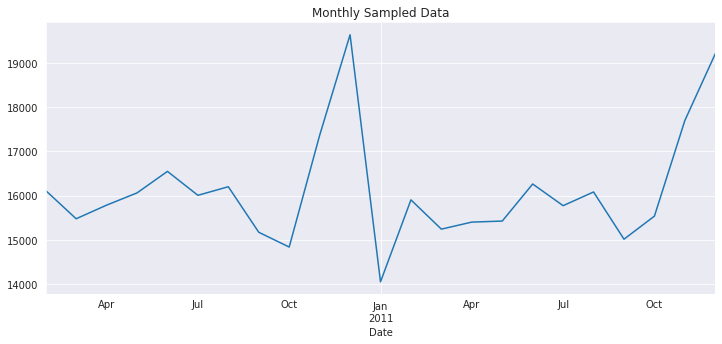

In [30]:
plt.figure(figsize=(12,5))
train_data_m.plot()
plt.title('Monthly Sampled Data')
plt.show()

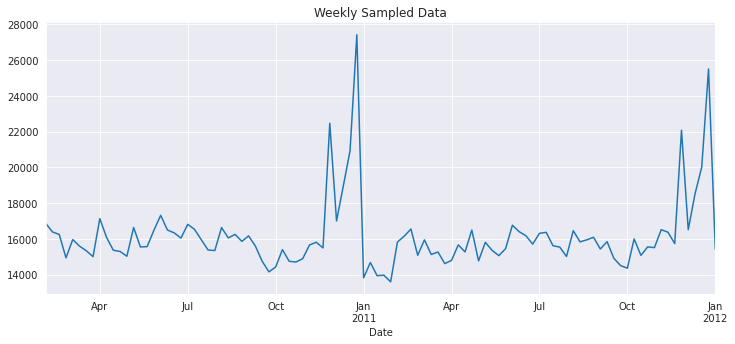

In [31]:
plt.figure(figsize=(12,5))
train_data_w.plot()
plt.title('Weekly Sampled Data')
plt.show()

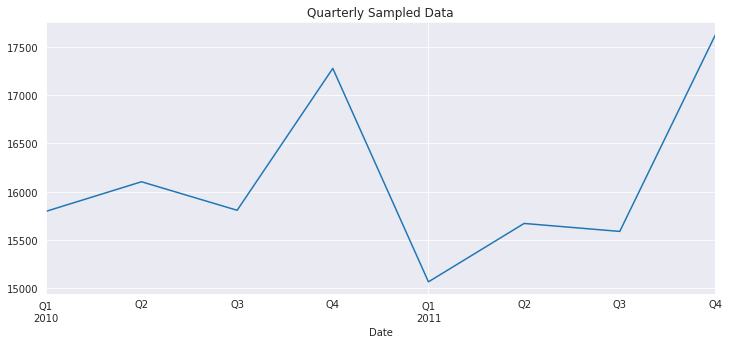

In [32]:
plt.figure(figsize=(12,5))
train_data_q.plot()
plt.title('Quarterly Sampled Data')
plt.show()

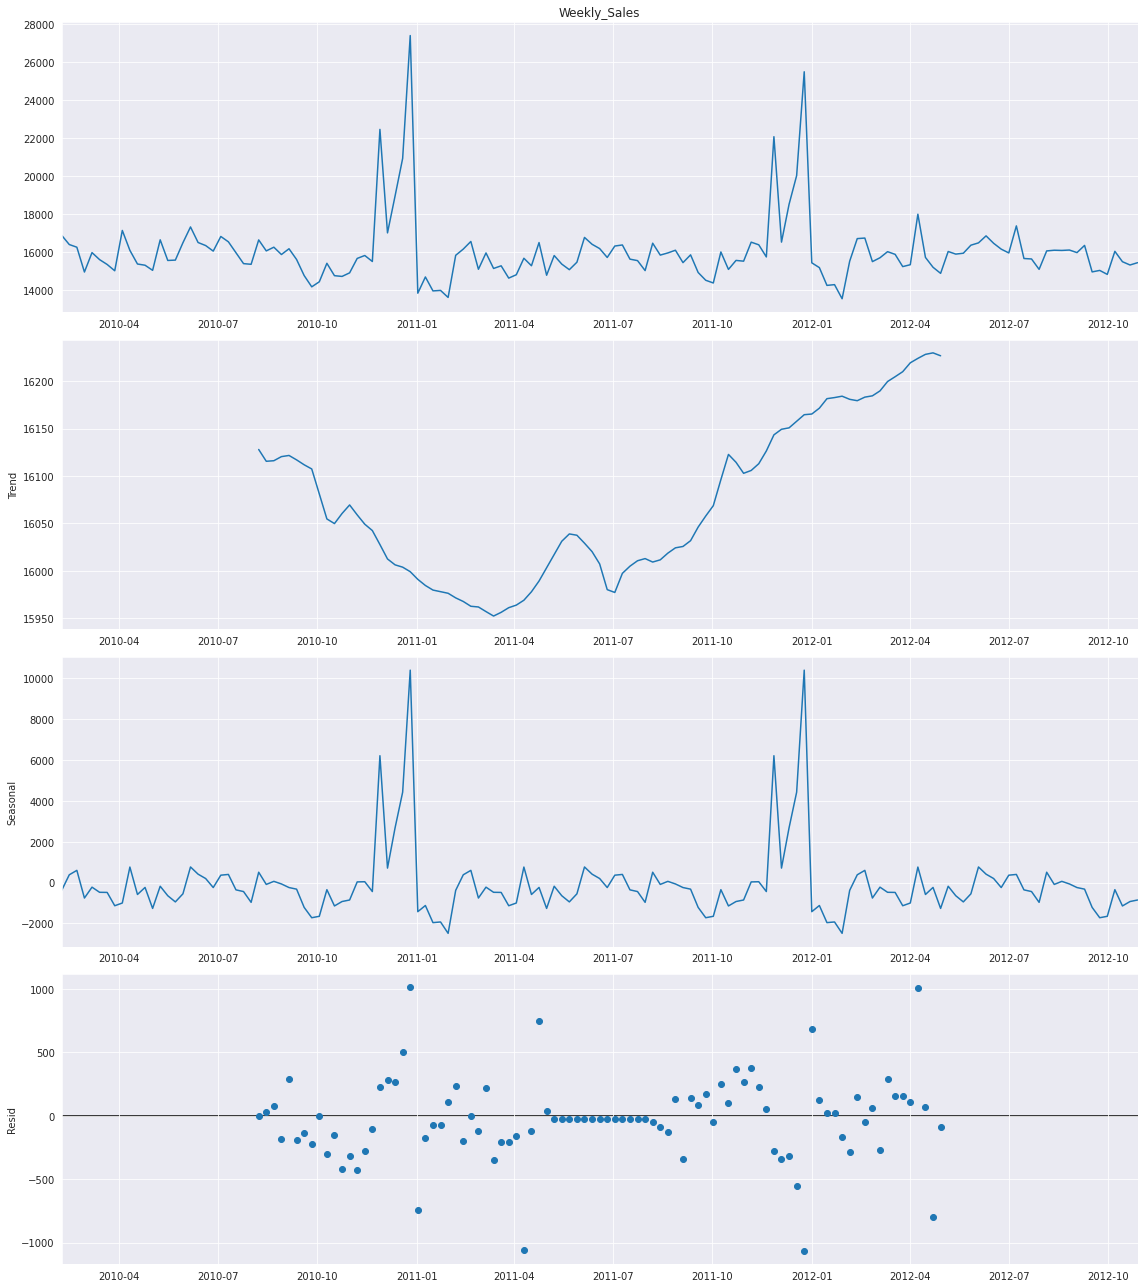

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 16,18
seasonal_decompose(df_weekly, model = 'additive').plot()
plt.show()

- The trend of weekly sales is such that it first decreases then elevates.
- Given OLX *dataset is **seasonal** dataset* as it is repeating the same pattern in the month of Nov-Dec.

______

Now we may require to perform some tests recurringly so we will define some reusable functions.

### Log Likelihood Ratio Test

For Model comparisions we will define a function for **Log Likelihood Ratio Test**

In [34]:
def LLR_test(mod_1, mod_2, DF=1):
    '''
    input model_1, model_2, degree of freedom (default = 1)
    '''
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

### Augmented Dickey-Fuller Test

We will define a Dickey-Fuller Test function for testing stationarity.

In [35]:
def adickeyFuller(series):
    result = adfuller(series)

    print('---Results of Dickey Fuller----\n')
    print('ADF Statistic: ', result[0])
    print('p-value: ', result[1])
    print('Critical Values:')
    for key,value in result[4].items():
        print('{}: {}'.format(key,value))

### ACF and PACF Plots

We will define a combined for plotting acfs and pacfs

In [36]:
def acf_pacf( series, acf = False, pacf = False, lags_ = None, title = ''):
    rcParams['figure.figsize'] = 8,3    
    if acf == True:
        sgt.plot_acf(series, zero = False, lags=lags_)
        plt.title("ACF "+ title + " ", size=20)
        plt.show()
    if pacf == True:
        sgt.plot_pacf(series, zero = False, lags = lags_)
        plt.title("PACF "+ title + " ", size=20)
        plt.show()

## ----------------------------------------------- FOR WEEKLY SAMPLING --------------------------------------------

#### Checking Stationarity

In [37]:
print("On Weekly Sampled Data\n")
print(adickeyFuller(df_weekly))

On Weekly Sampled Data

---Results of Dickey Fuller----

ADF Statistic:  -5.927437652782698
p-value:  2.424917229727546e-07
Critical Values:
1%: -3.47864788917503
5%: -2.882721765644168
10%: -2.578065326612056
None


- Since the p-value of the test is much less than the significance values for even 1%,   
we can be sure that our series is Stationary.

## The ***A***uto ***R***egression Model

We generally consider PACF for Auto Regressions.

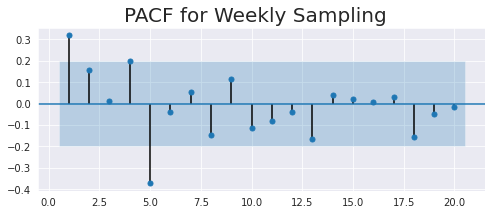

In [38]:
acf_pacf(train_data_w, pacf= True, title = 'for Weekly Sampling ')

- The above plots suggests that we have 3-4 significant values so we can try models having 3 lags to atleast 5 lags.

#### AR(1)

In [39]:
model_w_ar_1 = ARMA(train_data_w, order= (1,0)).fit()
model_w_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  100
Model:                     ARMA(1, 0)   Log Likelihood                -899.316
Method:                       css-mle   S.D. of innovations           1946.331
Date:                Sun, 13 Sep 2020   AIC                           1804.631
Time:                        15:48:42   BIC                           1812.447
Sample:                    02-07-2010   HQIC                          1807.794
                         - 01-01-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.615e+04    282.186     57.216      0.000    1.56e+04    1.67e+04
ar.L1.Weekly_Sales     0.3134      0.094      3.319      0.001       0.128       0.498
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1909           +0.0000j            3.1909            0.0000
-----------------------------------------------------------------------------
"""

- Since the p-values are significant for both the constant and the coefficient, we can try higher lag models.

#### AR(3)

In [40]:
model_w_ar_3 = ARMA(train_data_w, order= (3,0)).fit()
model_w_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  100
Model:                     ARMA(3, 0)   Log Likelihood                -897.905
Method:                       css-mle   S.D. of innovations           1918.388
Date:                Sun, 13 Sep 2020   AIC                           1805.810
Time:                        15:48:42   BIC                           1818.836
Sample:                    02-07-2010   HQIC                          1811.082
                         - 01-01-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.618e+04    346.243     46.737      0.000    1.55e+04    1.69e+04
ar.L1.Weekly_Sales     0.2471      0.102      2.423      0.015       0.047       0.447
ar.L2.Weekly_Sales     0.1846      0.115      1.600      0.110      -0.042       0.411
ar.L3.Weekly_Sales     0.0178      0.114      0.157      0.875      -0.205       0.240
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6595           +0.0000j            1.6595            0.0000
AR.2           -4.4897           +0.0000j            4.4897            0.5000
AR.3           -7.5322           +0.0000j            7.5322            0.5000
-----------------------------------------------------------------------------
"""

#### AR(5)

In [41]:
model_w_ar_5 = ARMA(train_data_w, order= (5,0)).fit()
model_w_ar_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  100
Model:                     ARMA(5, 0)   Log Likelihood                -886.916
Method:                       css-mle   S.D. of innovations           1707.163
Date:                Sun, 13 Sep 2020   AIC                           1787.832
Time:                        15:48:43   BIC                           1806.068
Sample:                    02-07-2010   HQIC                          1795.212
                         - 01-01-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.615e+04    279.390     57.790      0.000    1.56e+04    1.67e+04
ar.L1.Weekly_Sales     0.3319      0.092      3.600      0.000       0.151       0.513
ar.L2.Weekly_Sales     0.1310      0.101      1.291      0.197      -0.068       0.330
ar.L3.Weekly_Sales     0.0178      0.103      0.173      0.862      -0.184       0.220
ar.L4.Weekly_Sales     0.3468      0.102      3.410      0.001       0.147       0.546
ar.L5.Weekly_Sales    -0.4450      0.101     -4.415      0.000      -0.642      -0.247
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1012           -0.0000j            1.1012           -0.5000
AR.2           -0.1843           -1.1556j            1.1702           -0.2752
AR.3           -0.1843           +1.1556j            1.1702            0.2752
AR.4            1.1246           -0.4751j            1.2208           -0.0636
AR.5            1.1246           +0.4751j            1.2208            0.0636
-----------------------------------------------------------------------------
"""

- We see that we have 4 significant values and 3 non-significant.
- Also our latest lag is non-significant, so we should be stopping here.

Although we can have a look at how another lag higher model would perform.

#### AR(6)

In [42]:
model_w_ar_6 = ARMA(train_data_w, order= (6,0)).fit()
model_w_ar_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  100
Model:                     ARMA(6, 0)   Log Likelihood                -886.858
Method:                       css-mle   S.D. of innovations           1706.156
Date:                Sun, 13 Sep 2020   AIC                           1789.716
Time:                        15:48:45   BIC                           1810.557
Sample:                    02-07-2010   HQIC                          1798.151
                         - 01-01-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.614e+04    268.997     59.997      0.000    1.56e+04    1.67e+04
ar.L1.Weekly_Sales     0.3186      0.100      3.182      0.001       0.122       0.515
ar.L2.Weekly_Sales     0.1394      0.104      1.335      0.182      -0.065       0.344
ar.L3.Weekly_Sales     0.0178      0.103      0.173      0.863      -0.184       0.220
ar.L4.Weekly_Sales     0.3513      0.103      3.425      0.001       0.150       0.552
ar.L5.Weekly_Sales    -0.4324      0.107     -4.028      0.000      -0.643      -0.222
ar.L6.Weekly_Sales    -0.0385      0.113     -0.340      0.734      -0.261       0.184
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1009           -0.4649j            1.1951           -0.0636
AR.2            1.1009           +0.4649j            1.1951            0.0636
AR.3           -0.1645           -1.1555j            1.1671           -0.2725
AR.4           -0.1645           +1.1555j            1.1671            0.2725
AR.5           -1.1134           -0.0000j            1.1134           -0.5000
AR.6          -11.9815           -0.0000j           11.9815           -0.5000
-----------------------------------------------------------------------------
"""

- As expected we can observe that our last lag is non-significant so AR(6) is probably a reach..  

Let us see what the ***LLR Test*** suggest

In [43]:
print('\nLLR For AR(1) and AR(3):\n',LLR_test(model_w_ar_1, model_w_ar_3))
print('\nLLR For AR(3) and AR(5):\n',LLR_test(model_w_ar_3, model_w_ar_5))
print('\nLLR For AR(5) and AR(6):\n',LLR_test(model_w_ar_5, model_w_ar_6))


LLR For AR(1) and AR(3):
 0.093

LLR For AR(3) and AR(5):
 0.0

LLR For AR(5) and AR(6):
 0.734


- The above test suggests that more complex model than AR(3) is significantly better, 
- Although it also suggests that using AR(6) orver AR(5) would not be better for the model. 

But we will consider the results of AR(6) for comparisions.

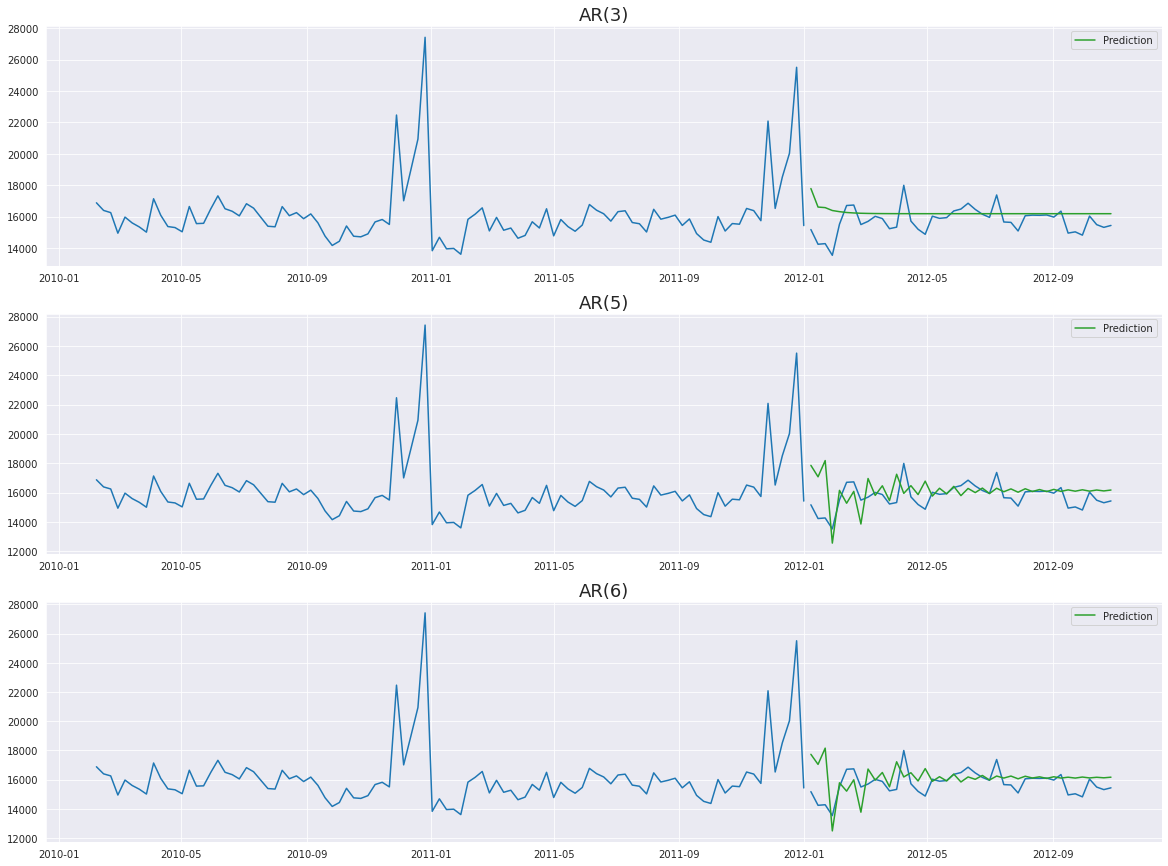

In [44]:
plt.figure(figsize=(20,15))

plt.subplot(3,1,1)
plt.plot(train_data_w, c= 'tab:blue')
plt.plot(test_data_w, c= 'tab:blue')
plt.title('AR(3)', size = 18)
plt.plot(model_w_ar_3.predict(start='2012-01-08', end= '2012-10-28'), c= 'tab:green', label = 'Prediction')
plt.legend()

plt.subplot(3,1,2)
plt.plot(train_data_w, c= 'tab:blue')
plt.plot(test_data_w, c= 'tab:blue')
plt.title('AR(5)', size = 18)
plt.plot(model_w_ar_5.predict(start='2012-01-08', end= '2012-10-28'), c= 'tab:green', label = 'Prediction')
plt.legend()

plt.subplot(3,1,3)
plt.plot(train_data_w, c= 'tab:blue')
plt.plot(test_data_w, c= 'tab:blue')
plt.title('AR(6)', size = 18)
plt.plot(model_w_ar_6.predict(start='2012-01-08', end= '2012-10-28'), c= 'tab:green', label = 'Prediction')
plt.legend()

plt.show()

#### Observing the residuals

In [45]:
print('Stationarity for Resiiduals\n')
adickeyFuller(model_w_ar_5.resid)

Stationarity for Resiiduals

---Results of Dickey Fuller----

ADF Statistic:  -9.89429414692825
p-value:  3.491045332468848e-17
Critical Values:
1%: -3.498198082189098
5%: -2.891208211860468
10%: -2.5825959973472097


The residual series is stationary but it is not same as white noise.   
We should also consider the ACF plots and none of the points should be significant.

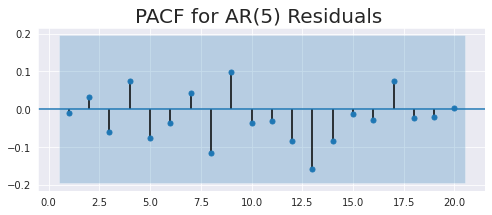

In [46]:
acf_pacf(model_w_ar_5.resid, pacf = True, title = 'for AR(5) Residuals')

- We can see that there are no significant points

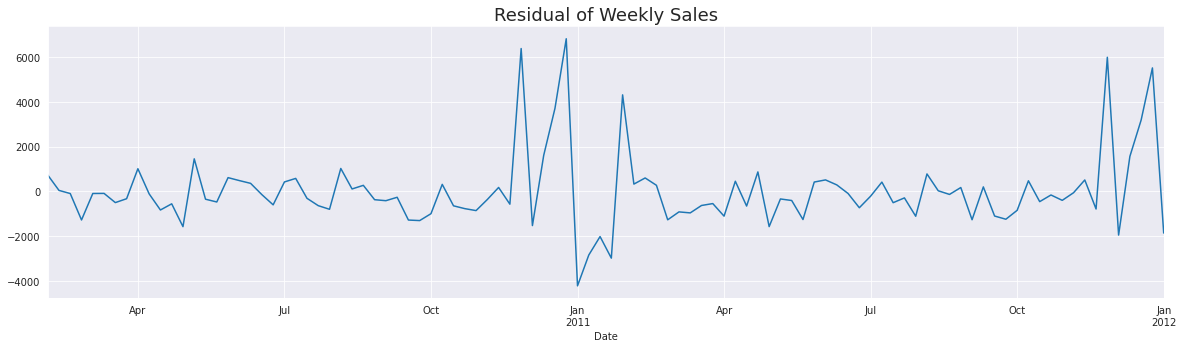

In [47]:
model_w_ar_5.resid.plot(figsize= (20,5))
plt.title('Residual of Weekly Sales', size = 18)
plt.show()

- Ideally the residuals should signify a ***Random Walk*** but,  
there seems to be an unaccounted pattern at the end of the year in the residuals.   

So we should try other models as well.

## The ***M***oving ***A***verage Model

For Moving Averages we consider the ACF Plot.

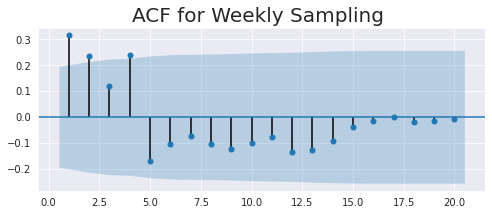

In [48]:
acf_pacf(train_data_w, acf= True, title = "for Weekly Sampling")

#### MA(1)

In [49]:
model_w_ma_1 = ARMA(train_data_w, order= (0,1)).fit()
model_w_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  100
Model:                     ARMA(0, 1)   Log Likelihood                -900.730
Method:                       css-mle   S.D. of innovations           1974.524
Date:                Sun, 13 Sep 2020   AIC                           1807.460
Time:                        15:48:48   BIC                           1815.276
Sample:                    02-07-2010   HQIC                          1810.623
                         - 01-01-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.614e+04    243.069     66.408      0.000    1.57e+04    1.66e+04
ma.L1.Weekly_Sales     0.2333      0.080      2.900      0.004       0.076       0.391
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -4.2872           +0.0000j            4.2872            0.5000
-----------------------------------------------------------------------------
"""

#### MA(3)

In [50]:
model_w_ma_3 = ARMA(train_data_w, order= (0,3)).fit()
model_w_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  100
Model:                     ARMA(0, 3)   Log Likelihood                -897.749
Method:                       css-mle   S.D. of innovations           1910.015
Date:                Sun, 13 Sep 2020   AIC                           1805.499
Time:                        15:48:49   BIC                           1818.525
Sample:                    02-07-2010   HQIC                          1810.770
                         - 01-01-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.611e+04    252.719     63.744      0.000    1.56e+04    1.66e+04
ma.L1.Weekly_Sales     0.5237      0.119      4.409      0.000       0.291       0.757
ma.L2.Weekly_Sales     0.1053      0.090      1.171      0.241      -0.071       0.282
ma.L3.Weekly_Sales    -0.3086      0.127     -2.439      0.015      -0.557      -0.061
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -0.8293           -0.9656j            1.2729           -0.3629
MA.2           -0.8293           +0.9656j            1.2729            0.3629
MA.3            2.0000           -0.0000j            2.0000           -0.0000
-----------------------------------------------------------------------------
"""

#### MA(4)

In [51]:
model_w_ma_4 = ARMA(train_data_w, order= (0,4)).fit()
model_w_ma_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  100
Model:                     ARMA(0, 4)   Log Likelihood                -885.468
Method:                       css-mle   S.D. of innovations           1674.021
Date:                Sun, 13 Sep 2020   AIC                           1782.936
Time:                        15:48:49   BIC                           1798.567
Sample:                    02-07-2010   HQIC                          1789.262
                         - 01-01-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.621e+04    415.632     39.009      0.000    1.54e+04     1.7e+04
ma.L1.Weekly_Sales     0.4315      0.100      4.335      0.000       0.236       0.627
ma.L2.Weekly_Sales     0.2929      0.084      3.481      0.000       0.128       0.458
ma.L3.Weekly_Sales     0.1637      0.089      1.830      0.067      -0.012       0.339
ma.L4.Weekly_Sales     0.6316      0.139      4.535      0.000       0.359       0.905
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -0.7862           -0.7232j            1.0682           -0.3816
MA.2           -0.7862           +0.7232j            1.0682            0.3816
MA.3            0.6566           -0.9780j            1.1779           -0.1559
MA.4            0.6566           +0.9780j            1.1779            0.1559
-----------------------------------------------------------------------------
"""

#### MA(5)

In [52]:
model_w_ma_5 = ARMA(train_data_w, order= (0,5)).fit()
model_w_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  100
Model:                     ARMA(0, 5)   Log Likelihood                -884.554
Method:                       css-mle   S.D. of innovations           1622.407
Date:                Sun, 13 Sep 2020   AIC                           1783.108
Time:                        15:48:50   BIC                           1801.344
Sample:                    02-07-2010   HQIC                          1790.489
                         - 01-01-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.621e+04    359.171     45.136      0.000    1.55e+04    1.69e+04
ma.L1.Weekly_Sales     0.4101      0.126      3.245      0.001       0.162       0.658
ma.L2.Weekly_Sales     0.2902      0.090      3.212      0.001       0.113       0.467
ma.L3.Weekly_Sales     0.0645      0.103      0.624      0.533      -0.138       0.267
ma.L4.Weekly_Sales     0.6367      0.135      4.729      0.000       0.373       0.901
ma.L5.Weekly_Sales    -0.1613      0.119     -1.358      0.174      -0.394       0.071
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -0.7404           -0.6722j            1.0000           -0.3827
MA.2           -0.7404           +0.6722j            1.0000            0.3827
MA.3            0.6146           -1.0482j            1.2151           -0.1656
MA.4            0.6146           +1.0482j            1.2151            0.1656
MA.5            4.1989           -0.0000j            4.1989           -0.0000
-----------------------------------------------------------------------------
"""

- Our lag is not significant anymore, so we will stop here.

And Compare the above models' performances

***LLR Test*** Results.

In [53]:
print('\nLLR For MA(1) and MA(3):\n',LLR_test(model_w_ma_1, model_w_ma_3))
print('\nLLR For MA(3) and MA(4):\n',LLR_test(model_w_ma_3, model_w_ma_5))
print('\nLLR For MA(4) and MA(5):\n',LLR_test(model_w_ma_4, model_w_ma_5))


LLR For MA(1) and MA(3):
 0.015

LLR For MA(3) and MA(4):
 0.0

LLR For MA(4) and MA(5):
 0.176


So using using MA(5) is not significant as shown in the test as well.

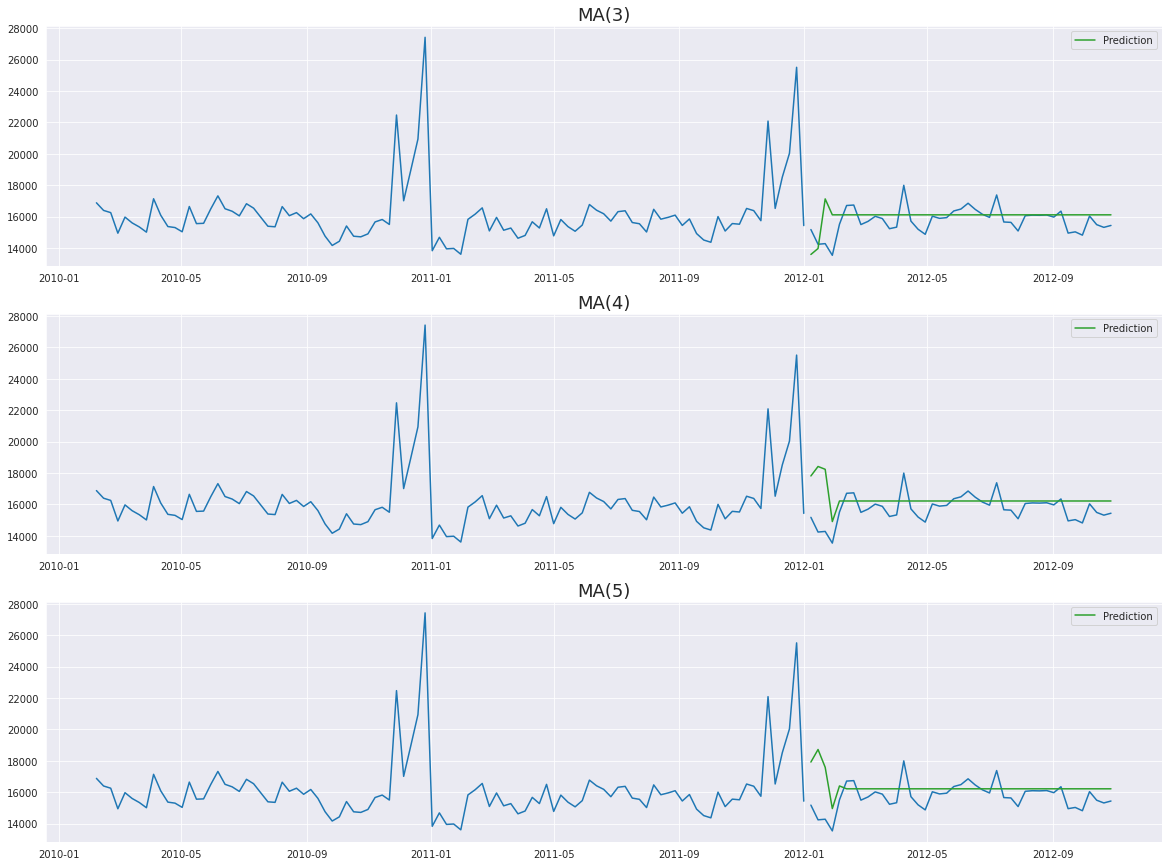

In [54]:
plt.figure(figsize=(20,15))

plt.subplot(3,1,1)
plt.plot(train_data_w, c= 'tab:blue')
plt.plot(test_data_w, c= 'tab:blue')
plt.title('MA(3)', size = 18)
plt.plot(model_w_ma_3.predict(start='2012-01-08', end= '2012-10-28'), c= 'tab:green', label = 'Prediction')
plt.legend()

plt.subplot(3,1,2)
plt.plot(train_data_w, c= 'tab:blue')
plt.plot(test_data_w, c= 'tab:blue')
plt.title('MA(4)', size = 18)
plt.plot(model_w_ma_4.predict(start='2012-01-08', end= '2012-10-28'), c= 'tab:green', label = 'Prediction')
plt.legend()

plt.subplot(3,1,3)
plt.plot(train_data_w, c= 'tab:blue')
plt.plot(test_data_w, c= 'tab:blue')
plt.title('MA(5)', size = 18)
plt.plot(model_w_ma_5.predict(start='2012-01-08', end= '2012-10-28'), c= 'tab:green', label = 'Prediction')
plt.legend()

plt.show()

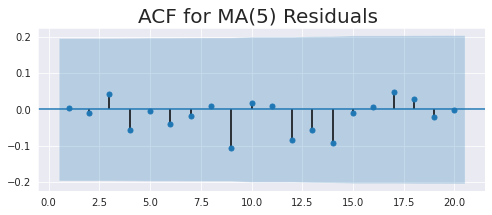

In [55]:
acf_pacf(model_w_ma_5.resid, acf = True, title = 'for MA(5) Residuals')

## The ***A***uto ***R***egression ***M***oving ***A***verage Models

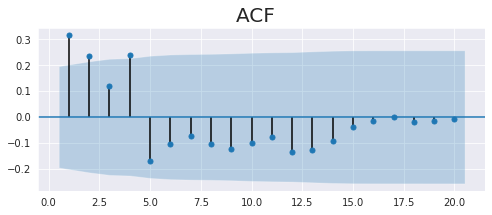

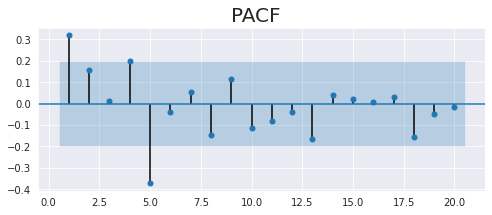

In [56]:
acf_pacf(train_data_w, acf = True, pacf= True)

For ARMA we will begin with complex models and slowly step down.

#### ARMA(5,2)

In [57]:
model_w_arma_5_2 = ARMA(train_data_w, order= (5,2)).fit()
model_w_arma_5_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  100
Model:                     ARMA(5, 2)   Log Likelihood                -886.779
Method:                       css-mle   S.D. of innovations           1704.668
Date:                Sun, 13 Sep 2020   AIC                           1791.557
Time:                        15:48:52   BIC                           1815.004
Sample:                    02-07-2010   HQIC                          1801.046
                         - 01-01-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.615e+04    290.726     55.558      0.000    1.56e+04    1.67e+04
ar.L1.Weekly_Sales     0.3059      0.327      0.935      0.350      -0.336       0.947
ar.L2.Weekly_Sales     0.0529      0.180      0.295      0.768      -0.299       0.405
ar.L3.Weekly_Sales     0.0447      0.135      0.330      0.741      -0.220       0.310
ar.L4.Weekly_Sales     0.3631      0.105      3.458      0.001       0.157       0.569
ar.L5.Weekly_Sales    -0.4375      0.134     -3.260      0.001      -0.701      -0.174
ma.L1.Weekly_Sales     0.0230      0.356      0.065      0.949      -0.675       0.721
ma.L2.Weekly_Sales     0.1043      0.242      0.431      0.667      -0.370       0.579
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1193           -0.0000j            1.1193           -0.5000
AR.2           -0.1723           -1.1284j            1.1415           -0.2741
AR.3           -0.1723           +1.1284j            1.1415            0.2741
AR.4            1.1468           -0.5018j            1.2518           -0.0656
AR.5            1.1468           +0.5018j            1.2518            0.0656
MA.1           -0.1100           -3.0940j            3.0960           -0.2557
MA.2           -0.1100           +3.0940j            3.0960            0.2557
-----------------------------------------------------------------------------
"""

#### ARMA(5,1)

In [58]:
model_w_arma_5_1 = ARMA(train_data_w, order= (5,1)).fit()
model_w_arma_5_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  100
Model:                     ARMA(5, 1)   Log Likelihood                -886.870
Method:                       css-mle   S.D. of innovations           1706.361
Date:                Sun, 13 Sep 2020   AIC                           1789.739
Time:                        15:48:53   BIC                           1810.581
Sample:                    02-07-2010   HQIC                          1798.174
                         - 01-01-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.614e+04    270.550     59.660      0.000    1.56e+04    1.67e+04
ar.L1.Weekly_Sales     0.3912      0.217      1.803      0.071      -0.034       0.816
ar.L2.Weekly_Sales     0.1145      0.117      0.977      0.329      -0.115       0.344
ar.L3.Weekly_Sales     0.0087      0.109      0.080      0.936      -0.205       0.222
ar.L4.Weekly_Sales     0.3493      0.104      3.368      0.001       0.146       0.553
ar.L5.Weekly_Sales    -0.4593      0.108     -4.244      0.000      -0.671      -0.247
ma.L1.Weekly_Sales    -0.0701      0.234     -0.300      0.765      -0.529       0.388
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1102           -0.0000j            1.1102           -0.5000
AR.2           -0.1685           -1.1569j            1.1691           -0.2730
AR.3           -0.1685           +1.1569j            1.1691            0.2730
AR.4            1.1038           -0.4653j            1.1979           -0.0635
AR.5            1.1038           +0.4653j            1.1979            0.0635
MA.1           14.2727           +0.0000j           14.2727            0.0000
-----------------------------------------------------------------------------
"""

#### ARMA(3,1)

In [59]:
model_w_arma_3_1 = ARMA(train_data_w, order= (3,1)).fit()
model_w_arma_3_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  100
Model:                     ARMA(3, 1)   Log Likelihood                -896.000
Method:                       css-mle   S.D. of innovations           1880.079
Date:                Sun, 13 Sep 2020   AIC                           1804.001
Time:                        15:48:53   BIC                           1819.632
Sample:                    02-07-2010   HQIC                          1810.327
                         - 01-01-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.616e+04    310.090     52.111      0.000    1.56e+04    1.68e+04
ar.L1.Weekly_Sales    -0.4147      0.173     -2.404      0.016      -0.753      -0.077
ar.L2.Weekly_Sales     0.4028      0.110      3.653      0.000       0.187       0.619
ar.L3.Weekly_Sales    -0.0246      0.126     -0.195      0.846      -0.272       0.223
ma.L1.Weekly_Sales     0.7176      0.140      5.120      0.000       0.443       0.992
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1169           +0.0000j            1.1169            0.5000
AR.2            2.4131           +0.0000j            2.4131            0.0000
AR.3           15.1100           +0.0000j           15.1100            0.0000
MA.1           -1.3935           +0.0000j            1.3935            0.5000
-----------------------------------------------------------------------------
"""

In [60]:
print('\nLLR For ARMA(3,1) and ARMA(5,1):\n',LLR_test(model_w_arma_3_1, model_w_arma_5_1))
print('\nLLR For ARMA(5,1) and ARMA(5,2):\n',LLR_test(model_w_arma_5_1, model_w_arma_5_2))


LLR For ARMA(3,1) and ARMA(5,1):
 0.0

LLR For ARMA(5,1) and ARMA(5,2):
 0.67


- ARMA(5,1) is significantly better than ARMA(3,1)  
- ARMA(5,2) isn't better than ARMA(5,1)

<span style="color:darkred">Note: If any of the nesting conditions had been broken, our LLR test would have been become void.</span>

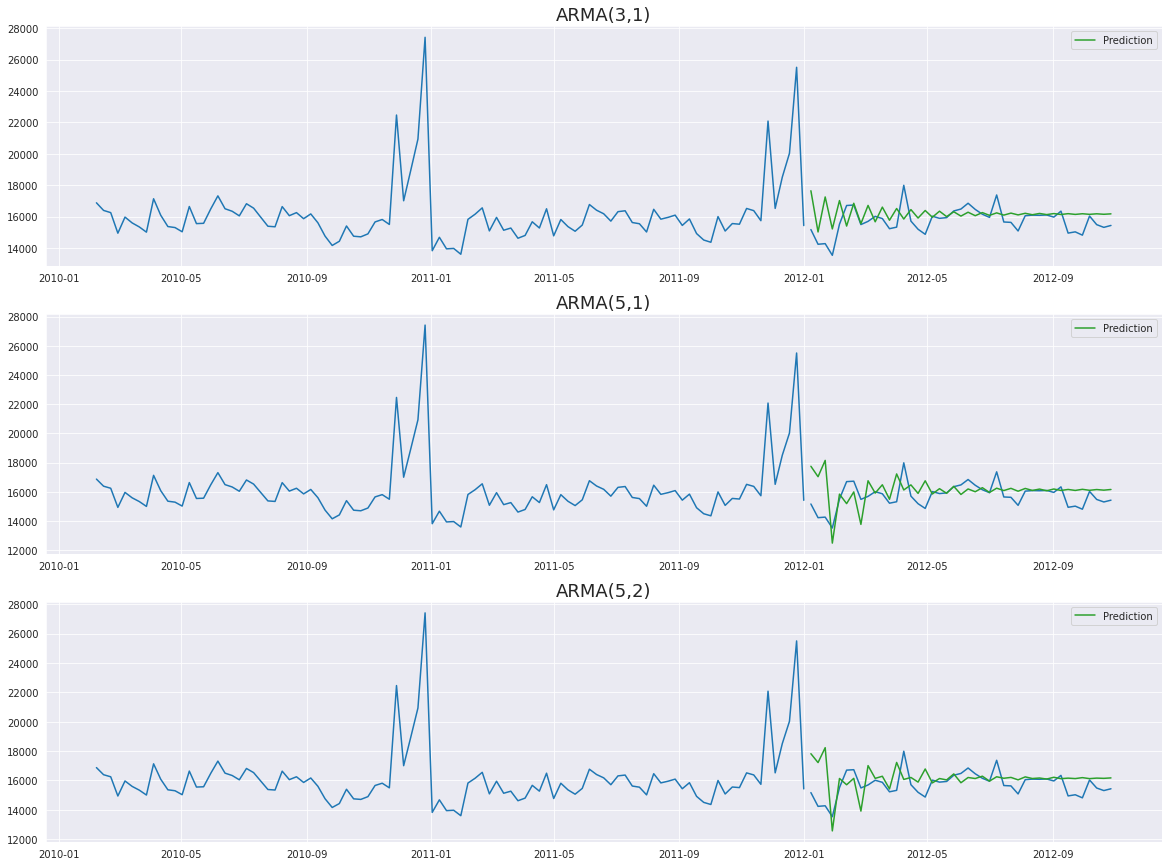

In [61]:
plt.figure(figsize=(20,15))

plt.subplot(3,1,1)
plt.plot(train_data_w, c= 'tab:blue')
plt.plot(test_data_w, c= 'tab:blue')
plt.title('ARMA(3,1)', size = 18)
plt.plot(model_w_arma_3_1.predict(start='2012-01-08', end= '2012-10-28'), c= 'tab:green', label = 'Prediction')
plt.legend()

plt.subplot(3,1,2)
plt.plot(train_data_w, c= 'tab:blue')
plt.plot(test_data_w, c= 'tab:blue')
plt.title('ARMA(5,1)', size = 18)
plt.plot(model_w_arma_5_1.predict(start='2012-01-08', end= '2012-10-28'), c= 'tab:green', label = 'Prediction')
plt.legend()

plt.subplot(3,1,3)
plt.plot(train_data_w, c= 'tab:blue')
plt.plot(test_data_w, c= 'tab:blue')
plt.title('ARMA(5,2)', size = 18)
plt.plot(model_w_arma_5_2.predict(start='2012-01-08', end= '2012-10-28'), c= 'tab:green', label = 'Prediction')
plt.legend()

plt.show()

#### Plots with probabilistic predictions

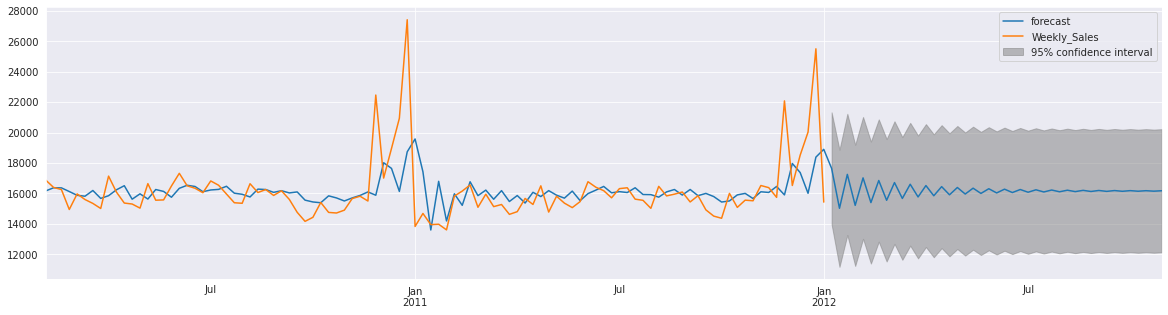

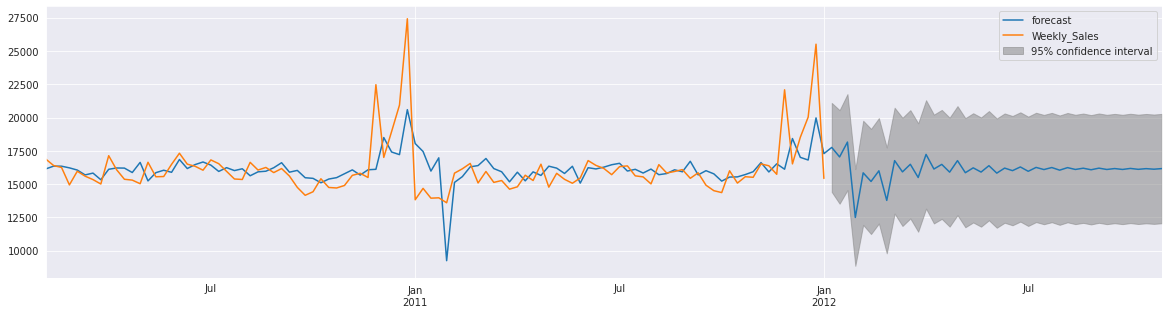

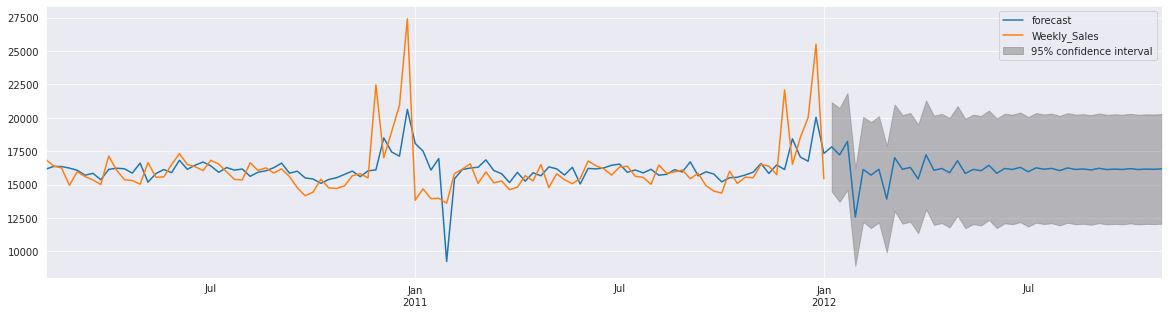

In [62]:
rcParams['figure.figsize'] = 20,5
model_w_arma_3_1.plot_predict(end= '2012-10-28')
model_w_arma_5_1.plot_predict(end= '2012-10-28')
model_w_arma_5_2.plot_predict(end= '2012-10-28')
plt.show()

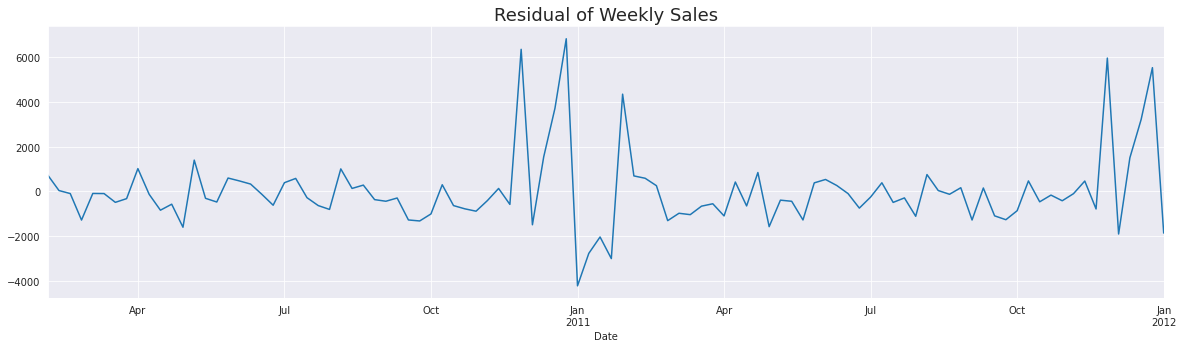

In [63]:
model_w_arma_5_1.resid.plot(figsize= (20,5))
plt.title('Residual of Weekly Sales', size = 18)
plt.show()

The residual pattern is still similar which was bound to happen.

## The ***A***uto ***R***egression ***I***ntegrated ***M***oving ***A***verage Model

#### <span style="color:darkred">Note: Since our Series is already stationary, we better not use ARIMA as we don't need the differencing part. I am  just trying  ARIMA here for exploratory purpose.</span>

In [64]:
model_w_arima_1_1_1 = ARIMA(train_data_w, order= (1,1,1)).fit()
model_w_arima_5_1_1 = ARIMA(train_data_w, order= (5,1,1)).fit()
model_w_arima_5_1_2 = ARIMA(train_data_w, order= (5,1,2)).fit()

In [65]:
print("ARIMA(1,1,1):  \t LL = ", model_w_arima_1_1_1.llf, "\t AIC = ", model_w_arima_1_1_1.aic)
print("ARIMA(5,1,1):  \t LL = ", model_w_arima_5_1_1.llf, "\t AIC = ", model_w_arima_5_1_1.aic)
print("ARIMA(5,1,2):  \t LL = ", model_w_arima_5_1_2.llf, "\t AIC = ", model_w_arima_5_1_2.aic)

ARIMA(1,1,1):  	 LL =  -892.4088335947431 	 AIC =  1792.8176671894862
ARIMA(5,1,1):  	 LL =  -880.0352945938205 	 AIC =  1776.070589187641
ARIMA(5,1,2):  	 LL =  -880.0213964610987 	 AIC =  1778.0427929221973


The ***ARIMA (5, 1, 1)*** seems to be a decent fit among these three.

In [66]:
print('\nLLR For ARIMA(1,1,1) and ARIMA(5,1,1):\n',LLR_test(model_w_arima_1_1_1, model_w_arima_5_1_1))
print('\nLLR For ARIMA(5,1,1) and ARIMA(5,1,2):\n',LLR_test(model_w_arima_5_1_1, model_w_arima_5_1_2))
# print('\nLLR For AR(5) and AR(6):\n',LLR_test(model_w_ar_5, model_w_ar_6))


LLR For ARIMA(1,1,1) and ARIMA(5,1,1):
 0.0

LLR For ARIMA(5,1,1) and ARIMA(5,1,2):
 0.868


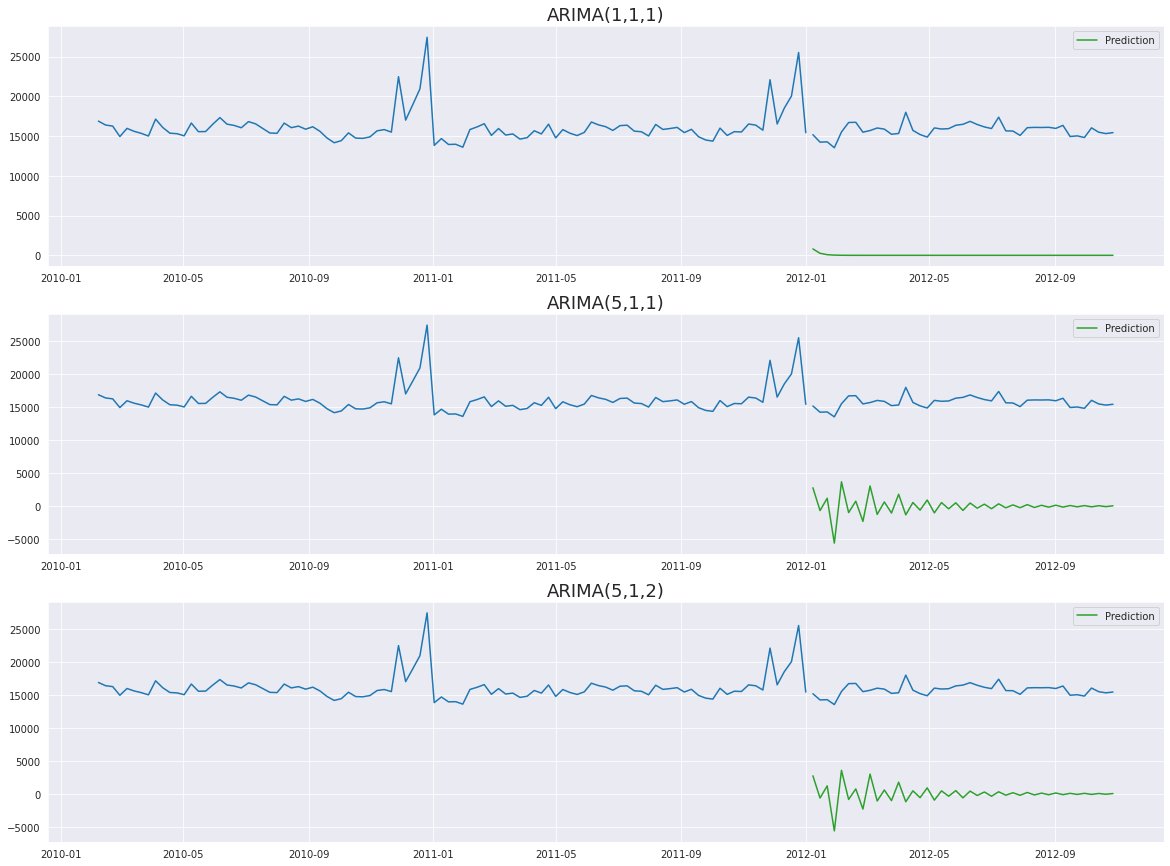

In [67]:
plt.figure(figsize=(20,15))

plt.subplot(3,1,1)
plt.plot(train_data_w, c= 'tab:blue')
plt.plot(test_data_w, c= 'tab:blue')
plt.title('ARIMA(1,1,1)', size = 18)
plt.plot(model_w_arima_1_1_1.predict(start='2012-01-08', end= '2012-10-28'), c= 'tab:green', label = 'Prediction')
plt.legend()

plt.subplot(3,1,2)
plt.plot(train_data_w, c= 'tab:blue')
plt.plot(test_data_w, c= 'tab:blue')
plt.title('ARIMA(5,1,1)', size = 18)
plt.plot(model_w_arima_5_1_1.predict(start='2012-01-08', end= '2012-10-28'), c= 'tab:green', label = 'Prediction')
plt.legend()

plt.subplot(3,1,3)
plt.plot(train_data_w, c= 'tab:blue')
plt.plot(test_data_w, c= 'tab:blue')
plt.title('ARIMA(5,1,2)', size = 18)
plt.plot(model_w_arima_5_1_2.predict(start='2012-01-08', end= '2012-10-28'), c= 'tab:green', label = 'Prediction')
plt.legend()

plt.show()

- As expected we are using differencing which is not required in our stationary series which is giving us these vertically shifted results.  

________________

#### None of our models that we have created address the Seasonality in the series.   
#### So now we will now create models that support seasonality.

## The ***S***easonal-***ARMA*** Model

#### Format for SARIMAX (***p***, ***d***, ***q***) (***P***, ***D***, ***Q***, ***s***)  

**p** - Trend Auto Regression  
**d** - Trend Difference Order  
**q** - Trend Moving Average  

**P** - Seasonal Auto Regression  
**D** - Seasonal Difference Order  
**Q** - Seasonal Moving Average

**s** - Length of Cycle

Here the exogenous parameter will be dropped to use *SARIMAX* as *SARIMA* and we'll also keep the differencing order 0 as our series is stationary.  
So we will have *SARMA* as final result.

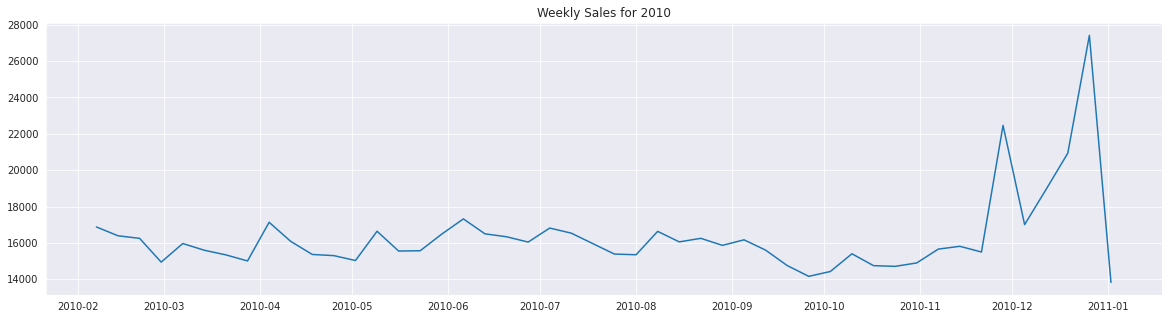

In [68]:
plt.title('Weekly Sales for 2010')
plt.plot(df_weekly[:48])
plt.show()

Since the hike appears after every 1 year and our periods are in weeks, we should be considering ***52*** as the ***length of cycle(s)***.

In [69]:
model_w_sarma_101_101_52 = SARIMAX(train_data_w, order = (1,1,1), seasonal_order= (1,0,1,52)).fit()
model_w_sarma_500_100_52 = SARIMAX(train_data_w, order = (5,0,0), seasonal_order= (1,0,0,52)).fit()
model_w_sarma_501_101_52 = SARIMAX(train_data_w, order = (5,0,1), seasonal_order= (1,0,1,52)).fit()

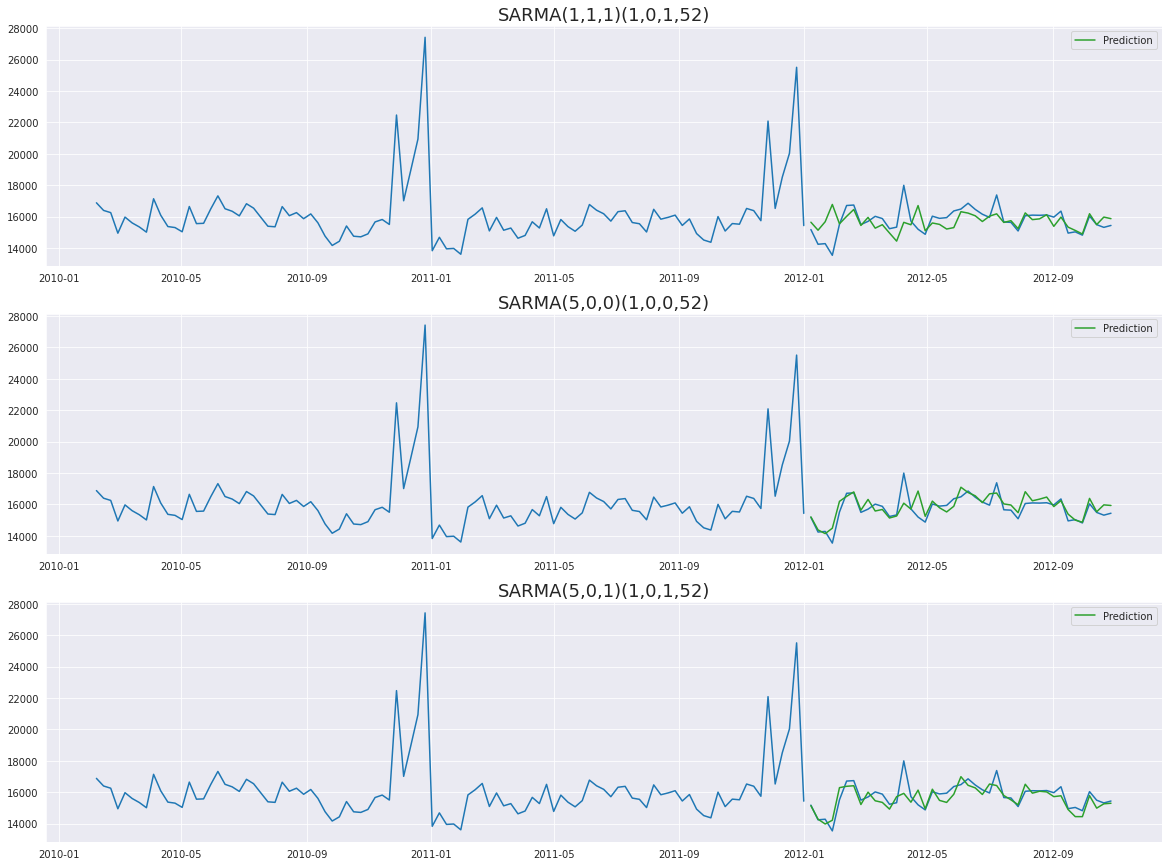

In [70]:
plt.figure(figsize=(20,15))

plt.subplot(3,1,1)
plt.plot(train_data_w, c= 'tab:blue')
plt.plot(test_data_w, c= 'tab:blue')
plt.title('SARMA(1,1,1)(1,0,1,52)', size = 18)
plt.plot(model_w_sarma_101_101_52.predict(start='2012-01-08', end= '2012-10-28'), c= 'tab:green', label = 'Prediction')
plt.legend()

plt.subplot(3,1,2)
plt.plot(train_data_w, c= 'tab:blue')
plt.plot(test_data_w, c= 'tab:blue')
plt.title('SARMA(5,0,0)(1,0,0,52)', size = 18)
plt.plot(model_w_sarma_500_100_52.predict(start='2012-01-08', end= '2012-10-28'), c= 'tab:green', label = 'Prediction')
plt.legend()

plt.subplot(3,1,3)
plt.plot(train_data_w, c= 'tab:blue')
plt.plot(test_data_w, c= 'tab:blue')
plt.title('SARMA(5,0,1)(1,0,1,52)', size = 18)
plt.plot(model_w_sarma_501_101_52.predict(start='2012-01-08', end= '2012-10-28'), c= 'tab:green', label = 'Prediction')
plt.legend()

plt.show()

#### Observing Error Terms

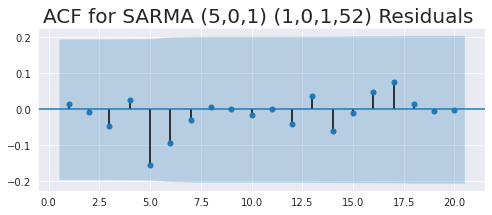

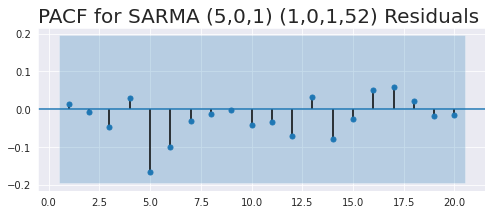

In [71]:
acf_pacf(model_w_sarma_501_101_52.resid, acf= True, pacf= True, title = 'for SARMA (5,0,1) (1,0,1,52) Residuals')

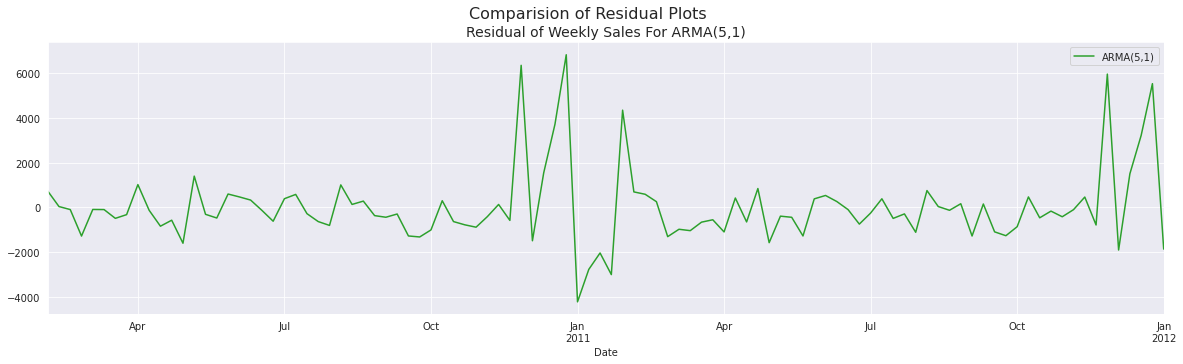

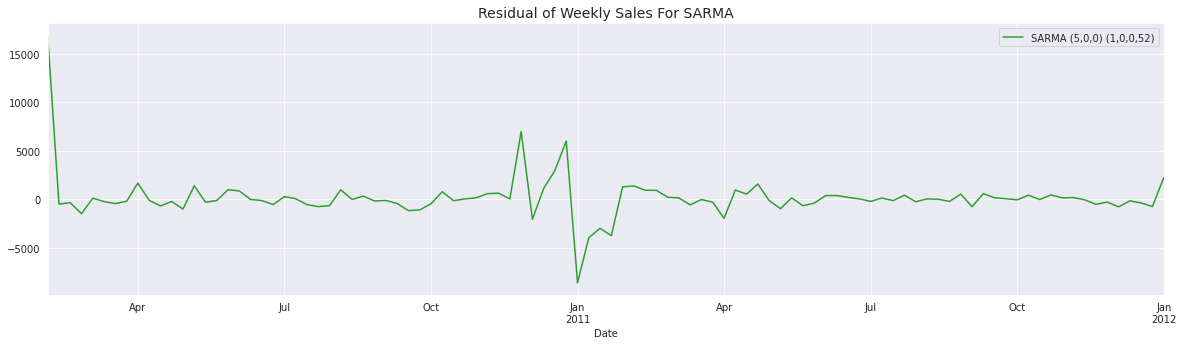

In [72]:
plt.suptitle('Comparision of Residual Plots', size = 16)

model_w_arma_5_1.resid.plot(figsize= (20,5), c = 'tab:green', label = 'ARMA(5,1)')
plt.title('Residual of Weekly Sales For ARMA(5,1)', size = 14)
plt.legend()
plt.show()
model_w_sarma_500_100_52.resid.plot(figsize= (20,5), c= 'tab:green', label = 'SARMA (5,0,0) (1,0,0,52)')
plt.title('Residual of Weekly Sales For SARMA', size = 14)
plt.legend()
plt.show()

- As evident from the residual plots of both of our higher lag **SARMA models**, we can now see that some of the unaccounted pattern that was emerging due to seasonality earlier has been accounted.  
- We can still see a **sharp variation** once which could be due to the inconsistency that for year **2010** our data starts from February.  

In [73]:
# DONT RUN THIS

# plt.suptitle('ARIMA Forecast From Monthly, Weekly and Quarterly Sampling', size = 18)

# for i, mwq in enumerate(['m', 'w', 'q']):
    
#     model_tmp = eval('arima_'+str(mwq)+'_fit')
#     test_data_tmp = eval('test_data_'+str(mwq))
#     train_data_tmp = eval('train_data_'+str(mwq))
    
#     tmp = pd.DataFrame(model_tmp.forecast(len(test_data_tmp))[0])
#     tmp.index = test_data_tmp.index

#     plt.subplot(3,1,i+1)
#     plt.plot(tmp, c = 'tab:orange', label = 'Predicted Sales')
#     plt.plot(test_data_tmp, c= 'tab:green', label = 'Actual Sales')
#     plt.plot(train_data_tmp, c= 'tab:green')
#     plt.legend()
#     plt.show()
    

## Smoothing

In [74]:
model_w_es_m = ExponentialSmoothing(train_data_w, seasonal_periods= 52, trend= 'multiplicative', seasonal= 'multiplicative').fit()
model_w_se_m = SimpleExpSmoothing(train_data_w).fit(smoothing_level=0.5, optimized=False)
model_w_hw_m = Holt(train_data_w).fit()

In [75]:
# sns.lineplot(df_weekly.index[101:], model_se_m.predict(43))

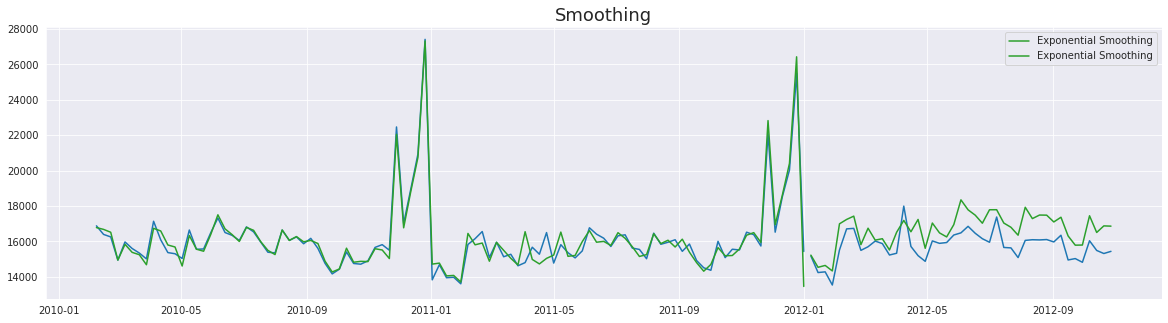

In [76]:
plt.figure(figsize=(20,5))
plt.plot(train_data_w, c= 'tab:blue')
plt.plot(test_data_w, c= 'tab:blue')
plt.title('Smoothing', size = 18)
plt.plot(model_w_es_m.predict(start='2012-01-08', end= '2012-10-28'), c= 'tab:green', label = 'Exponential Smoothing')
# plt.plot(model_w_se_m.predict(0), c= 'tab:orange', label = 'Simple Smoothing')
plt.plot(model_w_es_m.predict(0),c= 'tab:green', label = 'Exponential Smoothing')
# plt.plot(model_w_se_m.predict(start='2012-01-08', end= '2012-10-28'), c= 'tab:green', label = 'Exponential Smoothing')
plt.legend()
plt.show()

## Regression Model

In [77]:
X = data.copy()

In [78]:
# X = data[data['Dept'] == 5]
# X = X[X['Store'] == 5]

#### Label Encoding

In [79]:
X_full = X[['Store', 'IsHoliday', 'Temperature', 'Dept',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Year', 'Month', 'Week','Day']]

y_full = X['Weekly_Sales']

In [80]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [81]:
X_full['Type'] = encoder.fit_transform(X_full['Type'])
X_full['IsHoliday'] = encoder.fit_transform(X_full['IsHoliday'])

#### Choosing the most important features.

In [82]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(max_depth= 10)
regressor.fit(X_full, y_full)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [83]:
importances = regressor.feature_importances_
idx = importances.argsort()[-15:]

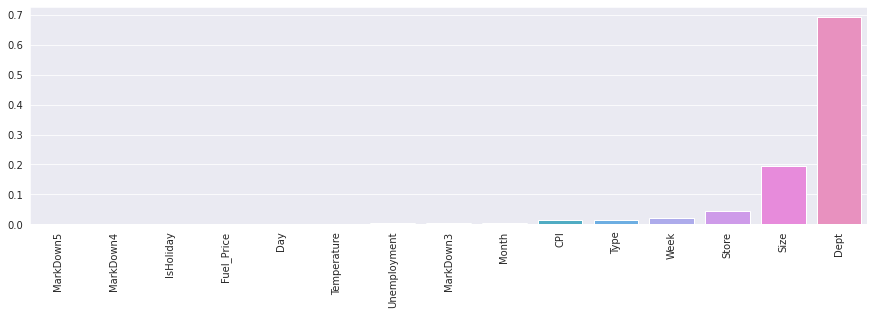

In [84]:
plt.figure(figsize=(15,4))
fig = sns.barplot(x = X_full.T.iloc[idx].index, y = importances[idx])
fig.set_xticklabels(fig.get_xticklabels(), rotation = 90)
plt.show()

Selecting the important features.

In [85]:
X_full = X_full[['Dept','Size', 'Store', 'Month', 'Type', 'CPI', 'Temperature', 'Store', 'Fuel_Price','Day', 'MarkDown3']]

In [86]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

#### Splitting the dataset

In [87]:
from sklearn.model_selection import train_test_split

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_full, test_size = 0.3, random_state = 101)

In [89]:
# X_train = X_full[:100]
# X_test = X_full[100:]
# y_train = y_full[:100]
# y_test = y_full[100:]

In [90]:
# from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# l_regressor = LinearRegression()
# l_regressor.fit(X_scaled, y_train)

rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [91]:
pred = rf_regressor.predict(X_train)
pred_test = rf_regressor.predict(X_test)

In [92]:
from sklearn.metrics import r2_score
print("The Adjusted-R2 Score is", r2_score(y_test, pred_test))

The Adjusted-R2 Score is 0.9717817761337428


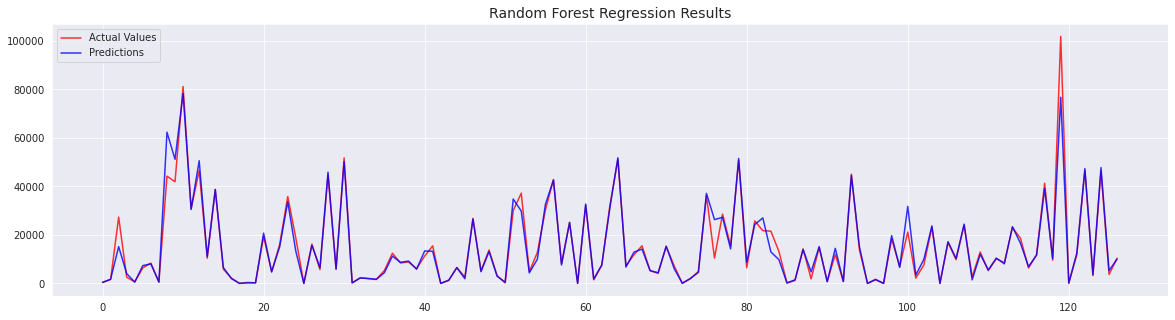

In [93]:
plt.figure(figsize=(20,5))
plt.plot(list(y_test.reset_index()['Weekly_Sales'][::1000]),alpha = 0.8, label = 'Actual Values', c= 'r')
plt.plot(pred_test[::1000],alpha = 0.8,c = 'b', label = 'Predictions')
plt.title('Random Forest Regression Results', size = 14)
plt.legend()
plt.show()

In [94]:
# tmp = pd.DataFrame(y_train)
# tmp.index = X['Date'][:100]
# tmp_test = pd.DataFrame(y_test)
# tmp_test.index = X['Date'][100:]


# tmp_pred = pd.DataFrame(pred)
# tmp_pred.index = X['Date'][:100]
# tmp_test_pred = pd.DataFrame(pred_test)
# tmp_test_pred.index = X['Date'][100:]

In [95]:
# plt.figure(figsize=(20,5))
# plt.plot(tmp, label = 'Train Set Actual')
# plt.plot(tmp_pred, label = 'Train Set Predictions')

# plt.plot(tmp_test, label = 'Test Set Actual')
# plt.plot(tmp_test_pred, label = 'Test Set Predictions')

# plt.title('Linear Regression')
# plt.legend()
# plt.show()

## Facebook **PROPHET**

In [96]:
from fbprophet import Prophet

In [97]:
datetime.strptime('2012-01-01','%Y-%m-%d')
php = Prophet(daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=True)

tmp = train_data_w.reset_index().rename(columns={'Date':'ds','Weekly_Sales':'y'})
php.fit(tmp)

In [98]:
future = php.make_future_dataframe(periods = 43+52, freq= 'W')
forecast = php.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

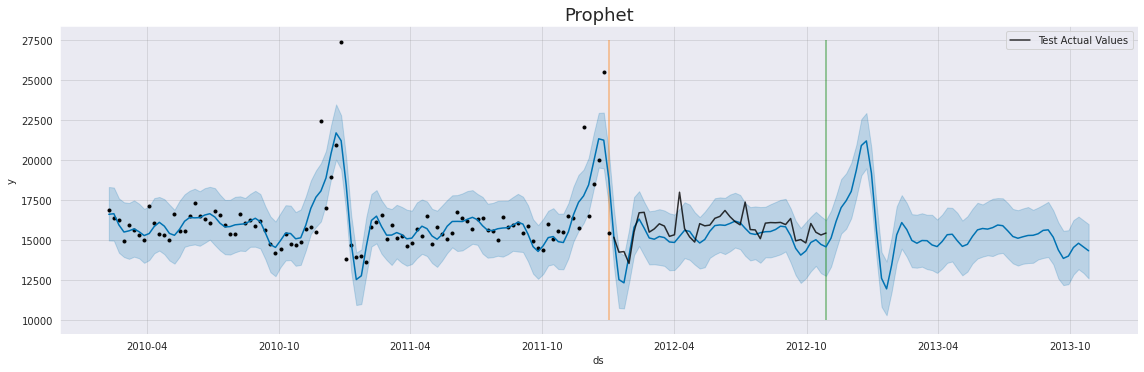

In [99]:
php.plot(forecast, figsize=(16,5))
plt.plot(test_data_w,'k', label = 'Test Actual Values', alpha = 0.8)
plt.vlines(datetime.strptime('2012-01-01','%Y-%m-%d'), ymin=10000, ymax = 27500, alpha = 0.5, color= 'tab:orange')
plt.vlines(datetime.strptime('2012-10-28','%Y-%m-%d'), ymin=10000, ymax = 27500, alpha = 0.5, color= 'g')
plt.title('Prophet', size = 18)
plt.legend()
plt.show()

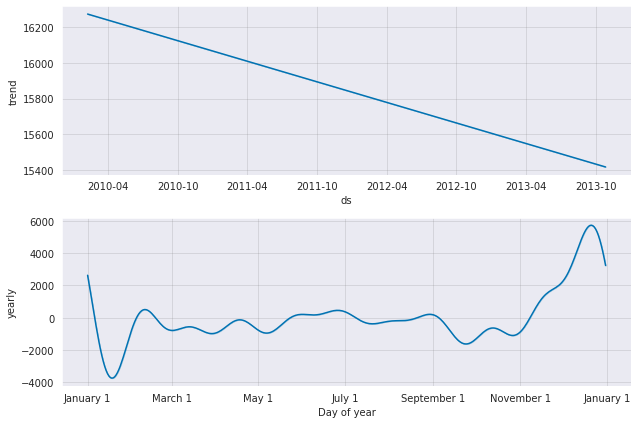

In [100]:
php.plot_components(forecast)
plt.show()

**<span style=color:darkred>Note: Dyanmic plots may not work on some platforms</style></span>**

In [101]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
# import plotly.graph_objects as go
py.init_notebook_mode()

fig = plot_plotly(php, forecast)
py.iplot(fig)

## ---------------------------------------------------------------------------------------------------------------

## Forecast on Single Dept and Single Store

Since all the studies tilll now were done on the resampled dataset of all departments aggregated over mean, the series did not belong to any particular department or any store.  

Each department would be a unique Time-Series on it's own as we can see from the plot below which is only for 10 departments out of all 81

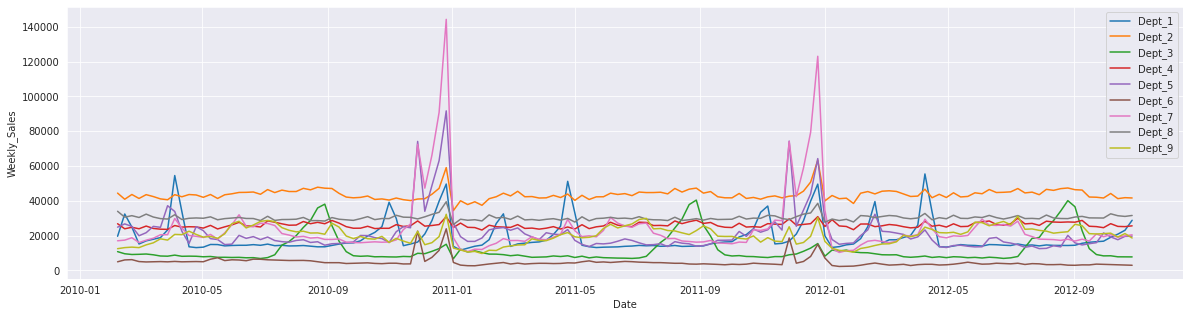

In [102]:
plt.figure(figsize=(20,5))
for i in range(1,10):
    tmp = data[data['Dept'] == i].set_index('Date').resample('W').mean()
    tmp_x = tmp.reset_index()['Date']
    tmp_y = tmp.reset_index()['Weekly_Sales']
    sns.lineplot(tmp_x, tmp_y, label = 'Dept_'+str(i))
plt.show()

We will now choose a particular department and average out its values across the stores.  
And we will access how they are previous models perform on individual departments.

In [103]:
X_f = data[data['Dept'] == 2]
X_f = X_f.set_index('Date').resample('W').mean() 

In [104]:
train_lr = X_f['Weekly_Sales'][:len(train_data_w)]
test_lr = X_f['Weekly_Sales'][len(train_data_w):]

In [105]:
tmp = pd.DataFrame(train_lr)
# tmp.index = X_f['Date'][:len(train_data_w)]
# ddf = ddf.resample('W').mean()

tmp_test = pd.DataFrame(test_lr)
# tmp_test.index = X_f['Date'][len(train_data_w):]
# ddf_test = ddf_test.resample('W').mean()

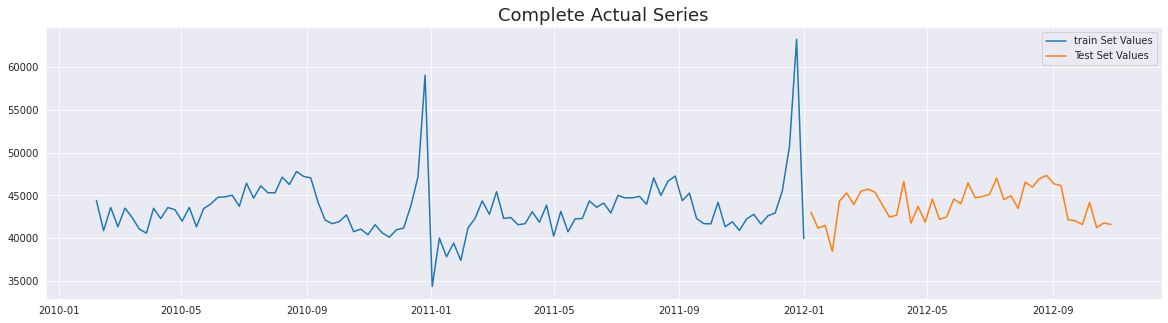

In [106]:
plt.figure(figsize=(20,5))
plt.plot(tmp, label = 'train Set Values')
plt.plot(tmp_test, label = 'Test Set Values')
plt.title('Complete Actual Series', size = 18)
plt.legend()
plt.show()

In [107]:
# SARIMAX(tmp, order = (3,0,3), seasonal_order= (1,0,0,52)).fit().summary()

For the forecasting model, we will include the observations from the test.

### SARMA Performance

In [108]:
model_r_sarma_303_100_52 = SARIMAX(tmp, order = (3,0,2), seasonal_order= (1,0,0,52)).fit()

In [109]:
# model_r_sarma_303_100_52.summary()

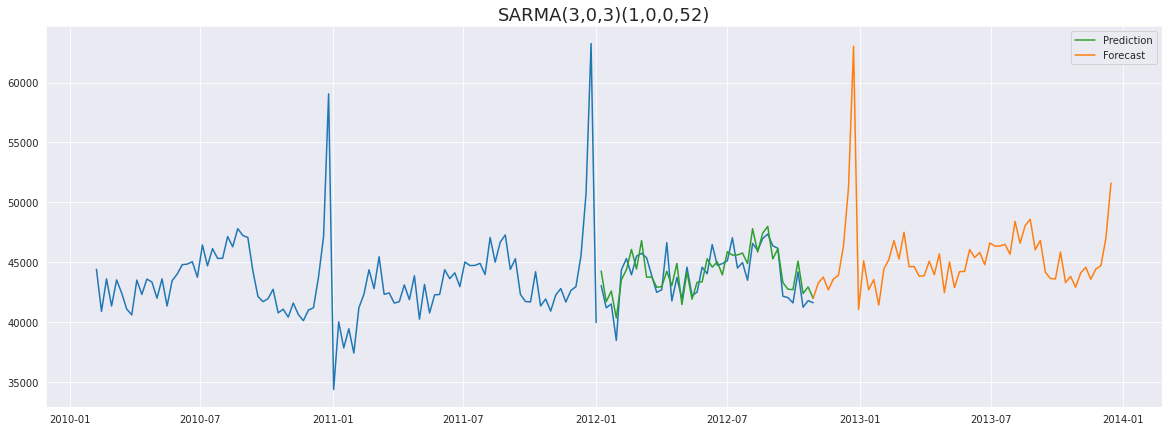

In [110]:
plt.figure(figsize=(20,7))
plt.plot(tmp, c= 'tab:blue')
plt.plot(tmp_test, c= 'tab:blue', alpha = 1)
plt.title('SARMA(3,0,3)(1,0,0,52)', size = 18)
plt.plot(model_r_sarma_303_100_52.predict(start='2012-01-08', end= '2012-10-28'), c= 'tab:green', label = 'Prediction')
plt.plot(model_r_sarma_303_100_52.predict(start='2012-10-28', end= '2013-12-15'), c= 'tab:orange', label = 'Forecast')
# plt.yticks(range(0,15000,5000))
plt.legend()
plt.show()

### Prophet Performance

In [111]:
tmp = tmp.reset_index().rename(columns = {'Date':'ds', 'Weekly_Sales':'y'})

In [112]:
m = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality= True)
m.fit(tmp)

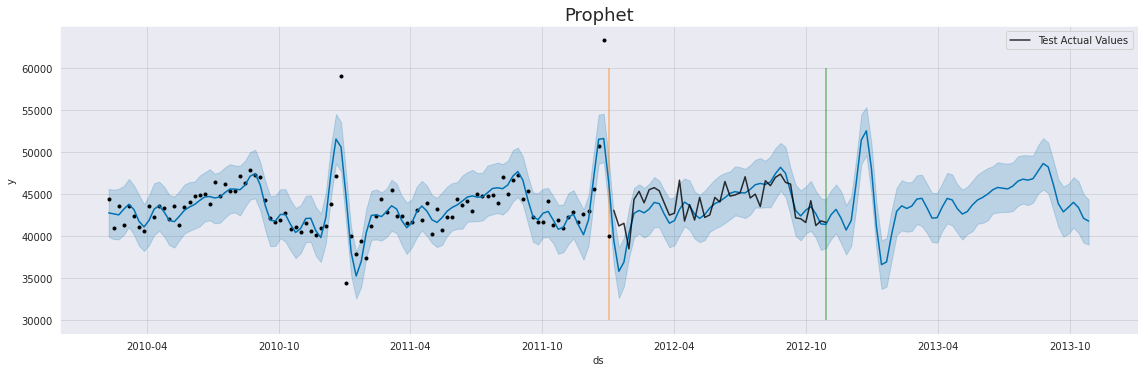

In [113]:
future = m.make_future_dataframe(periods=43+52, freq= 'W')
forecast = m.predict(future)
fig1 = m.plot(forecast, figsize=(16,5))
plt.plot(tmp_test, c= 'k', alpha = 0.8, label = 'Test Actual Values')
plt.vlines(datetime.strptime('2012-01-01','%Y-%m-%d'), ymin=30000, ymax = 60000, alpha = 0.5, color= 'tab:orange')
plt.vlines(datetime.strptime('2012-10-28','%Y-%m-%d'), ymin=30000, ymax = 60000, alpha = 0.5, color= 'g')
plt.title('Prophet', size = 18)
plt.legend()
plt.show()

**<span style=color:darkred>Note: Dyanmic plots may not work on some platforms</style></span>**

In [114]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
# import plotly.graph_objects as go
py.init_notebook_mode()

fig = plot_plotly(m, forecast)
py.iplot(fig)

### and that's it!